# BraTS23 INR Distillation (Tumour Probability)

This notebook trains a small implicit neural representation (INR) that maps 3D coordinates to tumour probability on BraTS23 volumes located under `data/`.

- Input: 3D coordinate x in [0,1]^3 (normalized voxel index).
- Target: tumour mask (1 if label>0).
- Model: Tiny MLP with Fourier features.
- Loss: BCE with class balancing.
- Output: Saved weights in `artifacts/inr_brats23.npz`.

You can later wire these weights into a differentiable Slang path (`renderPixelColorINR`) to render tumour probability directly during raymarch.

In [9]:
# Imports and basic config
import os, sys, json, math, random, time, pathlib
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    TORCH_OK = True
except Exception as e:
    print('Torch not available, falling back to NumPy (slow).', e)
    TORCH_OK = False

DATA_DIR = Path('data')
ARTIFACT_DIR = Path('artifacts'); ARTIFACT_DIR.mkdir(exist_ok=True)
RNG = np.random.default_rng(1337)

# Training config
FOURIER_BANDS = 8   # positional encoding bands
HIDDEN = 82         # hidden width
LAYERS = 3          # hidden layers
BATCH_POINTS = 32768  # number of random voxels per step
EPOCHS = 500
MAX_CASES = 1200        # limit for quick demo
DEVICE = 'cuda' if TORCH_OK and torch.cuda.is_available() else ('mps' if TORCH_OK and torch.backends.mps.is_available() else 'cpu')
DEVICE


'mps'

In [10]:
# Scan BraTS23 directory for cases with 4 modalities + seg.
def find_cases(root: Path):
    root = root.resolve()
    candidates = []
    for base in [root / 'BraTS-2023', root / 'BraTS-2023-Validation']:
        if not base.exists():
            continue
        for case_dir in base.rglob('*'):
            if not case_dir.is_dir():
                continue
            files = list(case_dir.glob('*.nii*'))
            if not files:
                continue
            # Heuristic: require modalities and segmentation file presence
            # Common suffixes: t1n, t1c, t2w, t2f, seg
            mod = {
                't1n': None, 't1c': None, 't2w': None, 't2f': None, 'seg': None
            }
            for f in files:
                name = f.name.lower()
                if 't1n' in name: mod['t1n'] = f
                elif 't1c' in name: mod['t1c'] = f
                elif 't2w' in name: mod['t2w'] = f
                elif 't2f' in name or 'flair' in name: mod['t2f'] = f
                elif 'seg' in name: mod['seg'] = f
            if mod['seg'] is not None and sum(x is not None for x in mod.values()) >= 2:
                candidates.append(mod)
    return candidates

cases = find_cases(DATA_DIR)
len(cases), cases[0] if cases else None


(1251,
 {'t1n': PosixPath('/Users/kylelukaszek/Classes/AI/Project/data/BraTS-2023/BraTS-GLI-00324-000/BraTS-GLI-00324-000-t1n.nii.gz'),
  't1c': PosixPath('/Users/kylelukaszek/Classes/AI/Project/data/BraTS-2023/BraTS-GLI-00324-000/BraTS-GLI-00324-000-t1c.nii.gz'),
  't2w': PosixPath('/Users/kylelukaszek/Classes/AI/Project/data/BraTS-2023/BraTS-GLI-00324-000/BraTS-GLI-00324-000-t2w.nii.gz'),
  't2f': PosixPath('/Users/kylelukaszek/Classes/AI/Project/data/BraTS-2023/BraTS-GLI-00324-000/BraTS-GLI-00324-000-t2f.nii.gz'),
  'seg': PosixPath('/Users/kylelukaszek/Classes/AI/Project/data/BraTS-2023/BraTS-GLI-00324-000/BraTS-GLI-00324-000-seg.nii.gz')})

In [11]:
# Utilities to load NIfTI volumes (float intensities, uint labels)
def load_nifti_float(path: Path):
    img = nib.load(str(path))
    vol = img.get_fdata(dtype=np.float32)
    vmin, vmax = np.percentile(vol, [1.0, 99.5])
    if vmax <= vmin: vmin, vmax = float(vol.min()), float(vol.max())
    rng = max(1e-6, vmax - vmin)
    vol = np.clip((vol - vmin)/rng, 0.0, 1.0).astype(np.float32)
    return vol

def load_nifti_label(path: Path):
    img = nib.load(str(path))
    lab = img.get_fdata(dtype=np.float32)
    lab = (lab > 0.5).astype(np.uint8)
    return lab

# Prepare a small list of cases
train_cases = cases[:MAX_CASES]
len(train_cases)


1200

In [12]:
# Simple dataset that samples random voxel coordinates and labels
class VoxelSampler:
    def __init__(self, case_dicts):
        self.vols = []  # list of (shape zyx) for sampling bounds
        self.labels = []
        for cd in case_dicts:
            segp = cd['seg']
            try:
                lab = load_nifti_label(segp)
            except Exception as e:
                print('Skip (bad seg):', segp, e)
                continue
            self.labels.append(lab)
            self.vols.append(lab.shape)
        self.n = len(self.labels)
        assert self.n > 0, 'No valid cases found with segmentation.'

    def sample(self, count):
        # Uniformly sample across cases
        xs, ys = [], []
        for _ in range(count):
            ci = RNG.integers(0, self.n)
            lab = self.labels[ci]
            D, H, W = lab.shape
            z = RNG.integers(0, D)
            y = RNG.integers(0, H)
            x = RNG.integers(0, W)
            # coord in [0,1]
            xs.append([x/(W-1+1e-6), y/(H-1+1e-6), z/(D-1+1e-6)])
            ys.append(1.0 if lab[z,y,x] > 0 else 0.0)
        X = np.asarray(xs, dtype=np.float32)
        Y = np.asarray(ys, dtype=np.float32)[:,None]
        return X, Y

sampler = VoxelSampler(train_cases)
print('Cases:', sampler.n)
Xb, Yb = sampler.sample(16)
Xb[:3], Yb[:3].T


Cases: 1200


(array([[0.18181819, 0.7280335 , 0.8786611 ],
        [0.9480519 , 0.38912132, 0.9246862 ],
        [0.11038961, 0.46025103, 0.87447697]], dtype=float32),
 array([[0., 0., 0.]], dtype=float32))

In [13]:
# INR model (PyTorch): Fourier features + small MLP
if TORCH_OK:
    class FourierPosEnc(nn.Module):
        def __init__(self, in_ch=3, bands=FOURIER_BANDS):
            super().__init__()
            self.bands = bands
            self.freqs = 2.0 ** torch.arange(bands).float() * math.pi
        def forward(self, x):  # x in [0,1]
            x = x * 2 - 1  # to [-1,1]
            f = self.freqs.to(x.device)
            xb = (x[...,None,:] * f[None,None,:,None]).view(x.shape[0], -1)
            return torch.cat([torch.sin(xb), torch.cos(xb)], dim=-1)

    class TinyINR(nn.Module):
        def __init__(self, bands=FOURIER_BANDS, hidden=HIDDEN, layers=LAYERS):
            super().__init__()
            self.pe = FourierPosEnc(3, bands)
            in_ch = 3 * bands * 2
            mlp = []
            c = in_ch
            for _ in range(layers):
                mlp += [nn.Linear(c, hidden), nn.ReLU(inplace=True)]
                c = hidden
            mlp += [nn.Linear(c, 1)]
            self.net = nn.Sequential(*mlp)
        def forward(self, x):
            f = self.pe(x)
            return self.net(f)  # logits

    model = TinyINR().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    print(model)
else:
    model = None
    print('NumPy mode: training loop will not run.')


TinyINR(
  (pe): FourierPosEnc()
  (net): Sequential(
    (0): Linear(in_features=48, out_features=82, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=82, out_features=82, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=82, out_features=82, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=82, out_features=1, bias=True)
  )
)


Output()

Epoch 1/500  loss=0.8382  p_pos=0.0118  time=0.2s


Epoch 2/500  loss=0.8222  p_pos=0.0115  time=0.2s


Epoch 3/500  loss=0.8051  p_pos=0.0113  time=0.3s


Epoch 4/500  loss=0.7855  p_pos=0.0108  time=0.2s


Epoch 5/500  loss=0.7738  p_pos=0.0108  time=0.2s


Epoch 6/500  loss=0.7586  p_pos=0.0107  time=0.2s
Epoch 7/500  loss=0.7583  p_pos=0.0113  time=0.2s


Epoch 8/500  loss=0.7424  p_pos=0.0111  time=0.2s
Epoch 9/500  loss=0.7288  p_pos=0.0111  time=0.2s


Epoch 10/500  loss=0.7134  p_pos=0.0110  time=0.2s
Epoch 11/500  loss=0.6790  p_pos=0.0101  time=0.2s


Epoch 12/500  loss=0.6815  p_pos=0.0107  time=0.2s
Epoch 13/500  loss=0.6950  p_pos=0.0116  time=0.2s


Epoch 14/500  loss=0.6944  p_pos=0.0119  time=0.2s
Epoch 15/500  loss=0.6445  p_pos=0.0107  time=0.2s


Epoch 16/500  loss=0.6446  p_pos=0.0109  time=0.2s
Epoch 17/500  loss=0.6005  p_pos=0.0097  time=0.2s


Epoch 18/500  loss=0.6233  p_pos=0.0107  time=0.2s
Epoch 19/500  loss=0.6292  p_pos=0.0109  time=0.2s


Epoch 20/500  loss=0.6428  p_pos=0.0113  time=0.2s
Epoch 21/500  loss=0.6061  p_pos=0.0104  time=0.2s


Epoch 22/500  loss=0.6450  p_pos=0.0114  time=0.2s
Epoch 23/500  loss=0.6078  p_pos=0.0107  time=0.2s


Epoch 24/500  loss=0.5830  p_pos=0.0100  time=0.2s
Epoch 25/500  loss=0.6320  p_pos=0.0113  time=0.2s


Epoch 26/500  loss=0.6373  p_pos=0.0117  time=0.2s
Epoch 27/500  loss=0.5731  p_pos=0.0103  time=0.2s


Epoch 28/500  loss=0.5859  p_pos=0.0106  time=0.1s
Epoch 29/500  loss=0.5957  p_pos=0.0110  time=0.1s


Epoch 30/500  loss=0.5755  p_pos=0.0107  time=0.2s
Epoch 31/500  loss=0.5728  p_pos=0.0107  time=0.2s


Epoch 32/500  loss=0.5913  p_pos=0.0114  time=0.2s
Epoch 33/500  loss=0.5456  p_pos=0.0103  time=0.2s


Epoch 34/500  loss=0.5456  p_pos=0.0103  time=0.2s
Epoch 35/500  loss=0.5329  p_pos=0.0102  time=0.2s


Epoch 36/500  loss=0.5686  p_pos=0.0115  time=0.2s
Epoch 37/500  loss=0.5215  p_pos=0.0100  time=0.2s


Epoch 38/500  loss=0.5461  p_pos=0.0109  time=0.1s
Epoch 39/500  loss=0.5198  p_pos=0.0103  time=0.1s


Epoch 40/500  loss=0.5268  p_pos=0.0108  time=0.2s
Epoch 41/500  loss=0.4996  p_pos=0.0103  time=0.2s


Epoch 42/500  loss=0.5220  p_pos=0.0109  time=0.2s
Epoch 43/500  loss=0.5086  p_pos=0.0108  time=0.2s


Epoch 44/500  loss=0.5100  p_pos=0.0108  time=0.2s
Epoch 45/500  loss=0.5120  p_pos=0.0110  time=0.2s


Epoch 46/500  loss=0.4976  p_pos=0.0109  time=0.2s
Epoch 47/500  loss=0.5259  p_pos=0.0121  time=0.1s


Epoch 48/500  loss=0.4433  p_pos=0.0098  time=0.2s
Epoch 49/500  loss=0.4772  p_pos=0.0109  time=0.1s


Epoch 50/500  loss=0.4634  p_pos=0.0109  time=0.2s
Epoch 51/500  loss=0.4411  p_pos=0.0102  time=0.2s


Epoch 52/500  loss=0.4559  p_pos=0.0110  time=0.1s
Epoch 53/500  loss=0.4237  p_pos=0.0102  time=0.1s


Epoch 54/500  loss=0.4537  p_pos=0.0111  time=0.2s
Epoch 55/500  loss=0.4534  p_pos=0.0111  time=0.1s


Epoch 56/500  loss=0.4364  p_pos=0.0110  time=0.1s
Epoch 57/500  loss=0.4279  p_pos=0.0106  time=0.2s


Epoch 58/500  loss=0.4375  p_pos=0.0114  time=0.1s
Epoch 59/500  loss=0.3817  p_pos=0.0094  time=0.1s


Epoch 60/500  loss=0.4074  p_pos=0.0105  time=0.2s
Epoch 61/500  loss=0.4192  p_pos=0.0111  time=0.2s


Epoch 62/500  loss=0.4074  p_pos=0.0109  time=0.1s
Epoch 63/500  loss=0.3907  p_pos=0.0107  time=0.1s


Epoch 64/500  loss=0.3835  p_pos=0.0101  time=0.2s
Epoch 65/500  loss=0.3878  p_pos=0.0105  time=0.1s


Epoch 66/500  loss=0.3930  p_pos=0.0109  time=0.1s
Epoch 67/500  loss=0.3735  p_pos=0.0103  time=0.2s


Epoch 68/500  loss=0.3505  p_pos=0.0099  time=0.1s
Epoch 69/500  loss=0.3890  p_pos=0.0112  time=0.1s


Epoch 70/500  loss=0.3537  p_pos=0.0102  time=0.2s
Epoch 71/500  loss=0.3774  p_pos=0.0111  time=0.2s


Epoch 72/500  loss=0.3719  p_pos=0.0110  time=0.1s
Epoch 73/500  loss=0.3663  p_pos=0.0111  time=0.1s


Epoch 74/500  loss=0.3776  p_pos=0.0119  time=0.1s
Epoch 75/500  loss=0.3492  p_pos=0.0106  time=0.2s


Epoch 76/500  loss=0.3524  p_pos=0.0109  time=0.1s
Epoch 77/500  loss=0.3636  p_pos=0.0115  time=0.1s


Epoch 78/500  loss=0.3357  p_pos=0.0108  time=0.2s
Epoch 79/500  loss=0.3449  p_pos=0.0110  time=0.1s


Epoch 80/500  loss=0.3337  p_pos=0.0108  time=0.2s
Epoch 81/500  loss=0.3181  p_pos=0.0102  time=0.2s


Epoch 82/500  loss=0.3365  p_pos=0.0109  time=0.1s
Epoch 83/500  loss=0.3249  p_pos=0.0106  time=0.1s


Epoch 84/500  loss=0.3266  p_pos=0.0108  time=0.2s
Epoch 85/500  loss=0.3334  p_pos=0.0109  time=0.1s


Epoch 86/500  loss=0.3035  p_pos=0.0102  time=0.1s
Epoch 87/500  loss=0.3050  p_pos=0.0103  time=0.1s


Epoch 88/500  loss=0.2944  p_pos=0.0097  time=0.2s
Epoch 89/500  loss=0.2977  p_pos=0.0099  time=0.1s


Epoch 90/500  loss=0.2897  p_pos=0.0100  time=0.2s
Epoch 91/500  loss=0.3057  p_pos=0.0107  time=0.2s


Epoch 92/500  loss=0.3087  p_pos=0.0109  time=0.1s
Epoch 93/500  loss=0.2976  p_pos=0.0106  time=0.1s


Epoch 94/500  loss=0.3092  p_pos=0.0107  time=0.1s
Epoch 95/500  loss=0.3074  p_pos=0.0113  time=0.2s


Epoch 96/500  loss=0.2865  p_pos=0.0107  time=0.1s
Epoch 97/500  loss=0.3033  p_pos=0.0111  time=0.1s


Epoch 98/500  loss=0.3001  p_pos=0.0111  time=0.2s
Epoch 99/500  loss=0.2906  p_pos=0.0109  time=0.1s


Epoch 100/500  loss=0.2803  p_pos=0.0101  time=0.2s
Epoch 101/500  loss=0.2719  p_pos=0.0100  time=0.1s


Epoch 102/500  loss=0.2928  p_pos=0.0109  time=0.2s
Epoch 103/500  loss=0.2919  p_pos=0.0110  time=0.1s


Epoch 104/500  loss=0.2799  p_pos=0.0106  time=0.1s
Epoch 105/500  loss=0.2945  p_pos=0.0107  time=0.2s


Epoch 106/500  loss=0.2876  p_pos=0.0113  time=0.1s
Epoch 107/500  loss=0.2850  p_pos=0.0107  time=0.1s


Epoch 108/500  loss=0.2905  p_pos=0.0114  time=0.2s
Epoch 109/500  loss=0.2815  p_pos=0.0114  time=0.1s


Epoch 110/500  loss=0.2929  p_pos=0.0107  time=0.2s
Epoch 111/500  loss=0.2857  p_pos=0.0112  time=0.1s


Epoch 112/500  loss=0.2830  p_pos=0.0109  time=0.2s
Epoch 113/500  loss=0.3017  p_pos=0.0123  time=0.1s


Epoch 114/500  loss=0.2849  p_pos=0.0113  time=0.1s
Epoch 115/500  loss=0.2707  p_pos=0.0102  time=0.2s


Epoch 116/500  loss=0.2742  p_pos=0.0106  time=0.1s
Epoch 117/500  loss=0.2765  p_pos=0.0114  time=0.1s


Epoch 118/500  loss=0.2957  p_pos=0.0120  time=0.1s
Epoch 119/500  loss=0.2779  p_pos=0.0105  time=0.2s


Epoch 120/500  loss=0.2875  p_pos=0.0114  time=0.2s
Epoch 121/500  loss=0.2694  p_pos=0.0106  time=0.1s


Epoch 122/500  loss=0.2807  p_pos=0.0114  time=0.2s
Epoch 123/500  loss=0.2630  p_pos=0.0102  time=0.1s


Epoch 124/500  loss=0.2737  p_pos=0.0102  time=0.1s
Epoch 125/500  loss=0.2650  p_pos=0.0102  time=0.2s


Epoch 126/500  loss=0.2668  p_pos=0.0106  time=0.1s
Epoch 127/500  loss=0.2804  p_pos=0.0111  time=0.1s


Epoch 128/500  loss=0.2715  p_pos=0.0114  time=0.2s
Epoch 129/500  loss=0.2660  p_pos=0.0106  time=0.1s


Epoch 130/500  loss=0.2723  p_pos=0.0109  time=0.2s
Epoch 131/500  loss=0.2622  p_pos=0.0105  time=0.1s


Epoch 132/500  loss=0.2624  p_pos=0.0107  time=0.2s
Epoch 133/500  loss=0.2850  p_pos=0.0107  time=0.1s


Epoch 134/500  loss=0.2708  p_pos=0.0108  time=0.1s
Epoch 135/500  loss=0.2796  p_pos=0.0116  time=0.2s


Epoch 136/500  loss=0.2645  p_pos=0.0105  time=0.1s
Epoch 137/500  loss=0.2769  p_pos=0.0113  time=0.1s


Epoch 138/500  loss=0.2711  p_pos=0.0104  time=0.1s
Epoch 139/500  loss=0.2751  p_pos=0.0107  time=0.2s


Epoch 140/500  loss=0.2727  p_pos=0.0109  time=0.2s
Epoch 141/500  loss=0.2676  p_pos=0.0108  time=0.1s


Epoch 142/500  loss=0.2572  p_pos=0.0104  time=0.2s
Epoch 143/500  loss=0.2753  p_pos=0.0117  time=0.1s


Epoch 144/500  loss=0.2725  p_pos=0.0105  time=0.1s
Epoch 145/500  loss=0.2973  p_pos=0.0131  time=0.1s


Epoch 146/500  loss=0.2675  p_pos=0.0104  time=0.2s
Epoch 147/500  loss=0.2673  p_pos=0.0108  time=0.1s


Epoch 148/500  loss=0.2507  p_pos=0.0103  time=0.1s
Epoch 149/500  loss=0.2634  p_pos=0.0107  time=0.2s


Epoch 150/500  loss=0.2675  p_pos=0.0118  time=0.2s
Epoch 151/500  loss=0.2617  p_pos=0.0103  time=0.1s


Epoch 152/500  loss=0.2592  p_pos=0.0103  time=0.1s
Epoch 153/500  loss=0.2645  p_pos=0.0110  time=0.2s


Epoch 154/500  loss=0.2664  p_pos=0.0105  time=0.1s
Epoch 155/500  loss=0.2550  p_pos=0.0106  time=0.1s


Epoch 156/500  loss=0.2549  p_pos=0.0109  time=0.1s
Epoch 157/500  loss=0.2690  p_pos=0.0114  time=0.2s


Epoch 158/500  loss=0.2687  p_pos=0.0111  time=0.1s
Epoch 159/500  loss=0.2686  p_pos=0.0109  time=0.1s


Epoch 160/500  loss=0.2555  p_pos=0.0097  time=0.2s
Epoch 161/500  loss=0.2646  p_pos=0.0106  time=0.1s


Epoch 162/500  loss=0.2523  p_pos=0.0102  time=0.1s
Epoch 163/500  loss=0.2657  p_pos=0.0110  time=0.2s


Epoch 164/500  loss=0.2715  p_pos=0.0114  time=0.1s
Epoch 165/500  loss=0.2706  p_pos=0.0113  time=0.1s


Epoch 166/500  loss=0.2734  p_pos=0.0109  time=0.2s
Epoch 167/500  loss=0.2561  p_pos=0.0109  time=0.1s


Epoch 168/500  loss=0.2814  p_pos=0.0116  time=0.1s
Epoch 169/500  loss=0.2593  p_pos=0.0111  time=0.1s


Epoch 170/500  loss=0.2679  p_pos=0.0106  time=0.2s
Epoch 171/500  loss=0.2621  p_pos=0.0115  time=0.1s


Epoch 172/500  loss=0.2695  p_pos=0.0111  time=0.1s
Epoch 173/500  loss=0.2657  p_pos=0.0105  time=0.1s


Epoch 174/500  loss=0.2655  p_pos=0.0115  time=0.2s
Epoch 175/500  loss=0.2622  p_pos=0.0104  time=0.1s


Epoch 176/500  loss=0.2694  p_pos=0.0116  time=0.1s
Epoch 177/500  loss=0.2667  p_pos=0.0111  time=0.2s


Epoch 178/500  loss=0.2704  p_pos=0.0111  time=0.1s
Epoch 179/500  loss=0.2574  p_pos=0.0106  time=0.1s


Epoch 180/500  loss=0.2588  p_pos=0.0102  time=0.2s
Epoch 181/500  loss=0.2741  p_pos=0.0113  time=0.1s


Epoch 182/500  loss=0.2680  p_pos=0.0112  time=0.1s
Epoch 183/500  loss=0.2599  p_pos=0.0107  time=0.1s


Epoch 184/500  loss=0.2694  p_pos=0.0110  time=0.2s
Epoch 185/500  loss=0.2619  p_pos=0.0102  time=0.1s


Epoch 186/500  loss=0.2904  p_pos=0.0121  time=0.1s
Epoch 187/500  loss=0.2630  p_pos=0.0110  time=0.2s


Epoch 188/500  loss=0.2636  p_pos=0.0111  time=0.1s
Epoch 189/500  loss=0.2662  p_pos=0.0108  time=0.1s


Epoch 190/500  loss=0.2497  p_pos=0.0097  time=0.2s
Epoch 191/500  loss=0.2668  p_pos=0.0101  time=0.2s


Epoch 192/500  loss=0.2580  p_pos=0.0105  time=0.1s
Epoch 193/500  loss=0.2580  p_pos=0.0107  time=0.1s


Epoch 194/500  loss=0.2724  p_pos=0.0113  time=0.2s
Epoch 195/500  loss=0.2654  p_pos=0.0114  time=0.1s


Epoch 196/500  loss=0.2519  p_pos=0.0094  time=0.1s
Epoch 197/500  loss=0.2560  p_pos=0.0112  time=0.1s


Epoch 198/500  loss=0.2686  p_pos=0.0115  time=0.2s
Epoch 199/500  loss=0.2556  p_pos=0.0109  time=0.1s


Epoch 200/500  loss=0.2576  p_pos=0.0111  time=0.2s
Epoch 201/500  loss=0.2600  p_pos=0.0103  time=0.2s


Epoch 202/500  loss=0.2421  p_pos=0.0095  time=0.1s
Epoch 203/500  loss=0.2365  p_pos=0.0105  time=0.1s


Epoch 204/500  loss=0.2527  p_pos=0.0110  time=0.2s
Epoch 205/500  loss=0.2677  p_pos=0.0107  time=0.1s


Epoch 206/500  loss=0.2618  p_pos=0.0111  time=0.1s
Epoch 207/500  loss=0.2421  p_pos=0.0093  time=0.1s


Epoch 208/500  loss=0.2636  p_pos=0.0106  time=0.2s
Epoch 209/500  loss=0.2801  p_pos=0.0116  time=0.1s


Epoch 210/500  loss=0.2501  p_pos=0.0105  time=0.2s
Epoch 211/500  loss=0.2753  p_pos=0.0110  time=0.2s


Epoch 212/500  loss=0.2575  p_pos=0.0108  time=0.1s
Epoch 213/500  loss=0.2595  p_pos=0.0112  time=0.1s


Epoch 214/500  loss=0.2610  p_pos=0.0110  time=0.1s
Epoch 215/500  loss=0.2522  p_pos=0.0112  time=0.2s


Epoch 216/500  loss=0.2509  p_pos=0.0104  time=0.1s
Epoch 217/500  loss=0.2721  p_pos=0.0111  time=0.1s


Epoch 218/500  loss=0.2457  p_pos=0.0103  time=0.2s
Epoch 219/500  loss=0.2405  p_pos=0.0099  time=0.1s


Epoch 220/500  loss=0.2516  p_pos=0.0101  time=0.2s
Epoch 221/500  loss=0.2609  p_pos=0.0105  time=0.1s


Epoch 222/500  loss=0.2648  p_pos=0.0108  time=0.2s
Epoch 223/500  loss=0.2567  p_pos=0.0100  time=0.1s


Epoch 224/500  loss=0.2548  p_pos=0.0107  time=0.1s
Epoch 225/500  loss=0.2591  p_pos=0.0107  time=0.2s


Epoch 226/500  loss=0.2663  p_pos=0.0110  time=0.1s
Epoch 227/500  loss=0.2597  p_pos=0.0113  time=0.1s


Epoch 228/500  loss=0.2573  p_pos=0.0106  time=0.1s
Epoch 229/500  loss=0.2615  p_pos=0.0103  time=0.2s


Epoch 230/500  loss=0.2746  p_pos=0.0114  time=0.2s
Epoch 231/500  loss=0.2529  p_pos=0.0103  time=0.1s


Epoch 232/500  loss=0.2637  p_pos=0.0110  time=0.2s
Epoch 233/500  loss=0.2487  p_pos=0.0105  time=0.1s


Epoch 234/500  loss=0.2518  p_pos=0.0104  time=0.1s
Epoch 235/500  loss=0.2437  p_pos=0.0105  time=0.2s


Epoch 236/500  loss=0.2537  p_pos=0.0103  time=0.1s
Epoch 237/500  loss=0.2421  p_pos=0.0106  time=0.1s


Epoch 238/500  loss=0.2512  p_pos=0.0107  time=0.1s
Epoch 239/500  loss=0.2654  p_pos=0.0111  time=0.2s


Epoch 240/500  loss=0.2626  p_pos=0.0108  time=0.2s
Epoch 241/500  loss=0.2608  p_pos=0.0112  time=0.2s


Epoch 242/500  loss=0.2598  p_pos=0.0111  time=0.1s
Epoch 243/500  loss=0.2550  p_pos=0.0099  time=0.1s


Epoch 244/500  loss=0.2592  p_pos=0.0113  time=0.1s
Epoch 245/500  loss=0.2554  p_pos=0.0107  time=0.2s


Epoch 246/500  loss=0.2367  p_pos=0.0101  time=0.1s
Epoch 247/500  loss=0.2658  p_pos=0.0111  time=0.1s


Epoch 248/500  loss=0.2554  p_pos=0.0112  time=0.2s
Epoch 249/500  loss=0.2590  p_pos=0.0106  time=0.1s


Epoch 250/500  loss=0.2475  p_pos=0.0096  time=0.2s
Epoch 251/500  loss=0.2626  p_pos=0.0115  time=0.1s


Epoch 252/500  loss=0.2602  p_pos=0.0106  time=0.2s
Epoch 253/500  loss=0.2857  p_pos=0.0125  time=0.1s


Epoch 254/500  loss=0.2574  p_pos=0.0104  time=0.1s
Epoch 255/500  loss=0.2596  p_pos=0.0108  time=0.1s


Epoch 256/500  loss=0.2600  p_pos=0.0107  time=0.2s
Epoch 257/500  loss=0.2701  p_pos=0.0114  time=0.1s


Epoch 258/500  loss=0.2541  p_pos=0.0112  time=0.1s
Epoch 259/500  loss=0.2410  p_pos=0.0099  time=0.2s


Epoch 260/500  loss=0.2598  p_pos=0.0113  time=0.2s
Epoch 261/500  loss=0.2625  p_pos=0.0108  time=0.1s


Epoch 262/500  loss=0.2337  p_pos=0.0098  time=0.2s
Epoch 263/500  loss=0.2662  p_pos=0.0117  time=0.1s


Epoch 264/500  loss=0.2580  p_pos=0.0106  time=0.1s
Epoch 265/500  loss=0.2617  p_pos=0.0107  time=0.2s


Epoch 266/500  loss=0.2796  p_pos=0.0113  time=0.1s
Epoch 267/500  loss=0.2557  p_pos=0.0109  time=0.1s


Epoch 268/500  loss=0.2717  p_pos=0.0114  time=0.1s
Epoch 269/500  loss=0.2479  p_pos=0.0099  time=0.2s


Epoch 270/500  loss=0.2525  p_pos=0.0104  time=0.2s
Epoch 271/500  loss=0.2635  p_pos=0.0109  time=0.1s


Epoch 272/500  loss=0.2569  p_pos=0.0111  time=0.1s
Epoch 273/500  loss=0.2569  p_pos=0.0098  time=0.2s


Epoch 274/500  loss=0.2505  p_pos=0.0107  time=0.1s
Epoch 275/500  loss=0.2649  p_pos=0.0114  time=0.1s


Epoch 276/500  loss=0.2574  p_pos=0.0115  time=0.2s
Epoch 277/500  loss=0.2597  p_pos=0.0107  time=0.1s


Epoch 278/500  loss=0.2435  p_pos=0.0103  time=0.1s
Epoch 279/500  loss=0.2722  p_pos=0.0112  time=0.2s


Epoch 280/500  loss=0.2615  p_pos=0.0110  time=0.2s
Epoch 281/500  loss=0.2527  p_pos=0.0107  time=0.1s


Epoch 282/500  loss=0.2750  p_pos=0.0109  time=0.2s
Epoch 283/500  loss=0.2722  p_pos=0.0115  time=0.1s


Epoch 284/500  loss=0.2492  p_pos=0.0107  time=0.1s
Epoch 285/500  loss=0.2540  p_pos=0.0105  time=0.1s


Epoch 286/500  loss=0.2656  p_pos=0.0116  time=0.2s
Epoch 287/500  loss=0.2614  p_pos=0.0109  time=0.1s


Epoch 288/500  loss=0.2629  p_pos=0.0112  time=0.1s
Epoch 289/500  loss=0.2581  p_pos=0.0114  time=0.2s


Epoch 290/500  loss=0.2689  p_pos=0.0114  time=0.2s
Epoch 291/500  loss=0.2550  p_pos=0.0108  time=0.1s


Epoch 292/500  loss=0.2515  p_pos=0.0106  time=0.1s
Epoch 293/500  loss=0.2426  p_pos=0.0108  time=0.2s


Epoch 294/500  loss=0.2407  p_pos=0.0105  time=0.1s
Epoch 295/500  loss=0.2586  p_pos=0.0105  time=0.1s


Epoch 296/500  loss=0.2471  p_pos=0.0107  time=0.2s
Epoch 297/500  loss=0.2535  p_pos=0.0108  time=0.1s


Epoch 298/500  loss=0.2471  p_pos=0.0105  time=0.1s
Epoch 299/500  loss=0.2560  p_pos=0.0103  time=0.2s


Epoch 300/500  loss=0.2633  p_pos=0.0107  time=0.2s
Epoch 301/500  loss=0.2522  p_pos=0.0108  time=0.1s


Epoch 302/500  loss=0.2565  p_pos=0.0115  time=0.2s
Epoch 303/500  loss=0.2633  p_pos=0.0116  time=0.1s


Epoch 304/500  loss=0.2632  p_pos=0.0110  time=0.1s
Epoch 305/500  loss=0.2443  p_pos=0.0100  time=0.1s


Epoch 306/500  loss=0.2685  p_pos=0.0114  time=0.2s
Epoch 307/500  loss=0.2642  p_pos=0.0110  time=0.1s


Epoch 308/500  loss=0.2666  p_pos=0.0112  time=0.1s
Epoch 309/500  loss=0.2536  p_pos=0.0105  time=0.1s


Epoch 310/500  loss=0.2580  p_pos=0.0116  time=0.2s
Epoch 311/500  loss=0.2523  p_pos=0.0097  time=0.1s


Epoch 312/500  loss=0.2428  p_pos=0.0099  time=0.1s
Epoch 313/500  loss=0.2391  p_pos=0.0108  time=0.2s


Epoch 314/500  loss=0.2835  p_pos=0.0116  time=0.1s
Epoch 315/500  loss=0.2494  p_pos=0.0102  time=0.1s


Epoch 316/500  loss=0.2521  p_pos=0.0107  time=0.2s
Epoch 317/500  loss=0.2485  p_pos=0.0104  time=0.1s


Epoch 318/500  loss=0.2547  p_pos=0.0110  time=0.1s
Epoch 319/500  loss=0.2480  p_pos=0.0108  time=0.1s


Epoch 320/500  loss=0.2490  p_pos=0.0101  time=0.2s
Epoch 321/500  loss=0.2563  p_pos=0.0112  time=0.1s


Epoch 322/500  loss=0.2458  p_pos=0.0113  time=0.1s
Epoch 323/500  loss=0.2591  p_pos=0.0114  time=0.2s


Epoch 324/500  loss=0.2509  p_pos=0.0108  time=0.1s
Epoch 325/500  loss=0.2495  p_pos=0.0107  time=0.1s


Epoch 326/500  loss=0.2525  p_pos=0.0105  time=0.1s
Epoch 327/500  loss=0.2337  p_pos=0.0095  time=0.2s


Epoch 328/500  loss=0.2554  p_pos=0.0102  time=0.1s
Epoch 329/500  loss=0.2616  p_pos=0.0117  time=0.1s


Epoch 330/500  loss=0.2512  p_pos=0.0103  time=0.2s
Epoch 331/500  loss=0.2577  p_pos=0.0107  time=0.1s


Epoch 332/500  loss=0.2420  p_pos=0.0103  time=0.1s
Epoch 333/500  loss=0.2648  p_pos=0.0111  time=0.1s


Epoch 334/500  loss=0.2525  p_pos=0.0113  time=0.2s
Epoch 335/500  loss=0.2576  p_pos=0.0109  time=0.1s


Epoch 336/500  loss=0.2553  p_pos=0.0101  time=0.1s
Epoch 337/500  loss=0.2501  p_pos=0.0106  time=0.2s


Epoch 338/500  loss=0.2456  p_pos=0.0103  time=0.1s
Epoch 339/500  loss=0.2603  p_pos=0.0117  time=0.1s


Epoch 340/500  loss=0.2480  p_pos=0.0109  time=0.2s
Epoch 341/500  loss=0.2608  p_pos=0.0111  time=0.1s


Epoch 342/500  loss=0.2546  p_pos=0.0106  time=0.1s
Epoch 343/500  loss=0.2530  p_pos=0.0108  time=0.2s


Epoch 344/500  loss=0.2516  p_pos=0.0100  time=0.1s
Epoch 345/500  loss=0.2597  p_pos=0.0114  time=0.1s


Epoch 346/500  loss=0.2527  p_pos=0.0107  time=0.1s
Epoch 347/500  loss=0.2588  p_pos=0.0112  time=0.2s


Epoch 348/500  loss=0.2579  p_pos=0.0107  time=0.1s
Epoch 349/500  loss=0.2535  p_pos=0.0107  time=0.1s


Epoch 350/500  loss=0.2546  p_pos=0.0113  time=0.2s
Epoch 351/500  loss=0.2557  p_pos=0.0103  time=0.1s


Epoch 352/500  loss=0.2460  p_pos=0.0110  time=0.1s
Epoch 353/500  loss=0.2479  p_pos=0.0104  time=0.1s


Epoch 354/500  loss=0.2406  p_pos=0.0103  time=0.2s
Epoch 355/500  loss=0.2496  p_pos=0.0099  time=0.1s


Epoch 356/500  loss=0.2474  p_pos=0.0109  time=0.1s
Epoch 357/500  loss=0.2657  p_pos=0.0120  time=0.2s


Epoch 358/500  loss=0.2767  p_pos=0.0112  time=0.1s
Epoch 359/500  loss=0.2496  p_pos=0.0108  time=0.1s


Epoch 360/500  loss=0.2479  p_pos=0.0107  time=0.2s
Epoch 361/500  loss=0.2625  p_pos=0.0109  time=0.2s


Epoch 362/500  loss=0.2577  p_pos=0.0107  time=0.1s
Epoch 363/500  loss=0.2514  p_pos=0.0107  time=0.1s


Epoch 364/500  loss=0.2480  p_pos=0.0104  time=0.2s
Epoch 365/500  loss=0.2528  p_pos=0.0107  time=0.1s


Epoch 366/500  loss=0.2605  p_pos=0.0111  time=0.1s
Epoch 367/500  loss=0.2470  p_pos=0.0103  time=0.2s


Epoch 368/500  loss=0.2390  p_pos=0.0102  time=0.1s
Epoch 369/500  loss=0.2608  p_pos=0.0107  time=0.1s


Epoch 370/500  loss=0.2397  p_pos=0.0100  time=0.2s
Epoch 371/500  loss=0.2434  p_pos=0.0105  time=0.2s


Epoch 372/500  loss=0.2633  p_pos=0.0112  time=0.1s
Epoch 373/500  loss=0.2660  p_pos=0.0115  time=0.1s


Epoch 374/500  loss=0.2489  p_pos=0.0098  time=0.2s
Epoch 375/500  loss=0.2500  p_pos=0.0109  time=0.1s


Epoch 376/500  loss=0.2343  p_pos=0.0100  time=0.1s
Epoch 377/500  loss=0.2545  p_pos=0.0100  time=0.1s


Epoch 378/500  loss=0.2473  p_pos=0.0101  time=0.2s
Epoch 379/500  loss=0.2758  p_pos=0.0114  time=0.1s


Epoch 380/500  loss=0.2480  p_pos=0.0099  time=0.2s
Epoch 381/500  loss=0.2522  p_pos=0.0101  time=0.2s


Epoch 382/500  loss=0.2544  p_pos=0.0113  time=0.1s
Epoch 383/500  loss=0.2395  p_pos=0.0110  time=0.1s


Epoch 384/500  loss=0.2568  p_pos=0.0109  time=0.1s
Epoch 385/500  loss=0.2344  p_pos=0.0102  time=0.2s


Epoch 386/500  loss=0.2566  p_pos=0.0106  time=0.1s
Epoch 387/500  loss=0.2434  p_pos=0.0106  time=0.1s


Epoch 388/500  loss=0.2647  p_pos=0.0118  time=0.1s
Epoch 389/500  loss=0.2567  p_pos=0.0106  time=0.2s


Epoch 390/500  loss=0.2468  p_pos=0.0101  time=0.2s
Epoch 391/500  loss=0.2526  p_pos=0.0114  time=0.1s


Epoch 392/500  loss=0.2639  p_pos=0.0126  time=0.2s
Epoch 393/500  loss=0.2473  p_pos=0.0116  time=0.1s


Epoch 394/500  loss=0.2553  p_pos=0.0104  time=0.1s
Epoch 395/500  loss=0.2589  p_pos=0.0117  time=0.2s


Epoch 396/500  loss=0.2606  p_pos=0.0107  time=0.1s
Epoch 397/500  loss=0.2747  p_pos=0.0109  time=0.1s


Epoch 398/500  loss=0.2741  p_pos=0.0108  time=0.1s
Epoch 399/500  loss=0.2527  p_pos=0.0107  time=0.2s


Epoch 400/500  loss=0.2576  p_pos=0.0109  time=0.2s
Epoch 401/500  loss=0.2517  p_pos=0.0103  time=0.1s


Epoch 402/500  loss=0.2659  p_pos=0.0107  time=0.2s
Epoch 403/500  loss=0.2458  p_pos=0.0100  time=0.1s


Epoch 404/500  loss=0.2739  p_pos=0.0103  time=0.1s
Epoch 405/500  loss=0.2539  p_pos=0.0110  time=0.2s


Epoch 406/500  loss=0.2652  p_pos=0.0122  time=0.1s
Epoch 407/500  loss=0.2723  p_pos=0.0114  time=0.1s


Epoch 408/500  loss=0.2497  p_pos=0.0111  time=0.1s
Epoch 409/500  loss=0.2637  p_pos=0.0114  time=0.2s


Epoch 410/500  loss=0.2675  p_pos=0.0110  time=0.2s
Epoch 411/500  loss=0.2479  p_pos=0.0107  time=0.1s


Epoch 412/500  loss=0.2486  p_pos=0.0110  time=0.2s
Epoch 413/500  loss=0.2523  p_pos=0.0106  time=0.1s


Epoch 414/500  loss=0.2591  p_pos=0.0108  time=0.1s
Epoch 415/500  loss=0.2616  p_pos=0.0110  time=0.1s


Epoch 416/500  loss=0.2386  p_pos=0.0106  time=0.2s
Epoch 417/500  loss=0.2528  p_pos=0.0108  time=0.1s


Epoch 418/500  loss=0.2527  p_pos=0.0110  time=0.1s
Epoch 419/500  loss=0.2516  p_pos=0.0108  time=0.2s


Epoch 420/500  loss=0.2513  p_pos=0.0110  time=0.2s
Epoch 421/500  loss=0.2361  p_pos=0.0099  time=0.1s


Epoch 422/500  loss=0.2511  p_pos=0.0101  time=0.2s
Epoch 423/500  loss=0.2639  p_pos=0.0112  time=0.1s


Epoch 424/500  loss=0.2417  p_pos=0.0105  time=0.1s
Epoch 425/500  loss=0.2610  p_pos=0.0107  time=0.1s


Epoch 426/500  loss=0.2593  p_pos=0.0104  time=0.2s
Epoch 427/500  loss=0.2611  p_pos=0.0112  time=0.1s


Epoch 428/500  loss=0.2479  p_pos=0.0103  time=0.1s
Epoch 429/500  loss=0.2532  p_pos=0.0106  time=0.2s


Epoch 430/500  loss=0.2436  p_pos=0.0102  time=0.2s
Epoch 431/500  loss=0.2556  p_pos=0.0102  time=0.1s


Epoch 432/500  loss=0.2596  p_pos=0.0113  time=0.1s
Epoch 433/500  loss=0.2622  p_pos=0.0110  time=0.2s


Epoch 434/500  loss=0.2568  p_pos=0.0109  time=0.1s
Epoch 435/500  loss=0.2460  p_pos=0.0099  time=0.1s


Epoch 436/500  loss=0.2615  p_pos=0.0121  time=0.2s
Epoch 437/500  loss=0.2521  p_pos=0.0118  time=0.1s


Epoch 438/500  loss=0.2536  p_pos=0.0100  time=0.1s
Epoch 439/500  loss=0.2532  p_pos=0.0101  time=0.1s


Epoch 440/500  loss=0.2394  p_pos=0.0090  time=0.2s
Epoch 441/500  loss=0.2633  p_pos=0.0112  time=0.1s


Epoch 442/500  loss=0.2421  p_pos=0.0106  time=0.1s
Epoch 443/500  loss=0.2634  p_pos=0.0107  time=0.2s


Epoch 444/500  loss=0.2711  p_pos=0.0114  time=0.1s
Epoch 445/500  loss=0.2419  p_pos=0.0095  time=0.1s


Epoch 446/500  loss=0.2460  p_pos=0.0104  time=0.1s
Epoch 447/500  loss=0.2583  p_pos=0.0110  time=0.2s


Epoch 448/500  loss=0.2517  p_pos=0.0108  time=0.1s
Epoch 449/500  loss=0.2418  p_pos=0.0104  time=0.1s


Epoch 450/500  loss=0.2492  p_pos=0.0101  time=0.2s
Epoch 451/500  loss=0.2410  p_pos=0.0099  time=0.2s


Epoch 452/500  loss=0.2491  p_pos=0.0104  time=0.1s
Epoch 453/500  loss=0.2545  p_pos=0.0102  time=0.1s


Epoch 454/500  loss=0.2627  p_pos=0.0118  time=0.2s
Epoch 455/500  loss=0.2350  p_pos=0.0102  time=0.1s


Epoch 456/500  loss=0.2485  p_pos=0.0099  time=0.1s
Epoch 457/500  loss=0.2567  p_pos=0.0105  time=0.2s


Epoch 458/500  loss=0.2729  p_pos=0.0124  time=0.1s
Epoch 459/500  loss=0.2533  p_pos=0.0107  time=0.1s


Epoch 460/500  loss=0.2510  p_pos=0.0107  time=0.2s
Epoch 461/500  loss=0.2545  p_pos=0.0107  time=0.2s


Epoch 462/500  loss=0.2514  p_pos=0.0107  time=0.1s
Epoch 463/500  loss=0.2417  p_pos=0.0103  time=0.1s


Epoch 464/500  loss=0.2552  p_pos=0.0106  time=0.2s
Epoch 465/500  loss=0.2506  p_pos=0.0105  time=0.1s


Epoch 466/500  loss=0.2551  p_pos=0.0103  time=0.1s
Epoch 467/500  loss=0.2504  p_pos=0.0114  time=0.1s


Epoch 468/500  loss=0.2539  p_pos=0.0110  time=0.2s
Epoch 469/500  loss=0.2425  p_pos=0.0102  time=0.1s


Epoch 470/500  loss=0.2675  p_pos=0.0111  time=0.2s
Epoch 471/500  loss=0.2607  p_pos=0.0115  time=0.2s


Epoch 472/500  loss=0.2576  p_pos=0.0110  time=0.1s
Epoch 473/500  loss=0.2393  p_pos=0.0108  time=0.1s


Epoch 474/500  loss=0.2648  p_pos=0.0108  time=0.2s
Epoch 475/500  loss=0.2456  p_pos=0.0107  time=0.1s


Epoch 476/500  loss=0.2548  p_pos=0.0105  time=0.1s
Epoch 477/500  loss=0.2569  p_pos=0.0110  time=0.1s


Epoch 478/500  loss=0.2348  p_pos=0.0101  time=0.2s
Epoch 479/500  loss=0.2509  p_pos=0.0106  time=0.1s


Epoch 480/500  loss=0.2497  p_pos=0.0105  time=0.2s
Epoch 481/500  loss=0.2633  p_pos=0.0110  time=0.2s


Epoch 482/500  loss=0.2549  p_pos=0.0102  time=0.1s
Epoch 483/500  loss=0.2469  p_pos=0.0107  time=0.1s


Epoch 484/500  loss=0.2631  p_pos=0.0114  time=0.1s
Epoch 485/500  loss=0.2531  p_pos=0.0107  time=0.2s


Epoch 486/500  loss=0.2513  p_pos=0.0109  time=0.1s
Epoch 487/500  loss=0.2512  p_pos=0.0113  time=0.1s


Epoch 488/500  loss=0.2563  p_pos=0.0115  time=0.2s
Epoch 489/500  loss=0.2475  p_pos=0.0105  time=0.1s


Epoch 490/500  loss=0.2521  p_pos=0.0113  time=0.2s
Epoch 491/500  loss=0.2484  p_pos=0.0099  time=0.1s


Epoch 492/500  loss=0.2447  p_pos=0.0106  time=0.2s
Epoch 493/500  loss=0.2550  p_pos=0.0114  time=0.1s


Epoch 494/500  loss=0.2418  p_pos=0.0102  time=0.1s
Epoch 495/500  loss=0.2640  p_pos=0.0110  time=0.2s


Epoch 496/500  loss=0.2713  p_pos=0.0114  time=0.1s
Epoch 497/500  loss=0.2490  p_pos=0.0109  time=0.1s


Epoch 498/500  loss=0.2618  p_pos=0.0118  time=0.2s
Epoch 499/500  loss=0.2313  p_pos=0.0098  time=0.1s


Epoch 500/500  loss=0.2593  p_pos=0.0110  time=0.2s


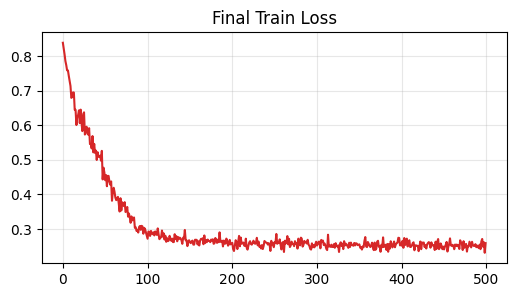

In [14]:
# Training loop (a few epochs)
loss_hist = []
if TORCH_OK:
    from IPython.display import display, clear_output
    import ipywidgets as widgets
    loss_view = widgets.Output()
    display(loss_view)
    fig, ax = plt.subplots(figsize=(6,3))
    pos_weight = None
    for epoch in range(EPOCHS):
        t0 = time.time()
        Xb, Yb = sampler.sample(BATCH_POINTS)
        p = max(1e-4, float(Yb.mean()))
        pos_weight = torch.tensor([(1.0-p)/max(p,1e-4)]).clamp(max=25.0).to(DEVICE)
        x = torch.from_numpy(Xb).to(DEVICE)
        y = torch.from_numpy(Yb).to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y, pos_weight=pos_weight)
        loss.backward()
        opt.step()
        loss_hist.append(float(loss.item()))
        if (epoch+1) % 10 == 0 or epoch < 5:
            with loss_view:
                clear_output(wait=True)
                ax.clear()
                ax.plot(loss_hist, color='tab:red')
                ax.set_title('Train Loss')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('BCE')
                ax.grid(alpha=0.3)
                display(fig)
        print(f'Epoch {epoch+1}/{EPOCHS}  loss={loss.item():.4f}  p_pos={p:.4f}  time={time.time()-t0:.1f}s')
    with loss_view:
        clear_output(wait=True)
        ax.clear(); ax.plot(loss_hist, color='tab:red'); ax.set_title('Final Train Loss'); ax.grid(alpha=0.3); display(fig)
else:
    print('Torch not available — skipping training.')


In [15]:
# Save weights for later use in Slang (JSON/npz)
if TORCH_OK:
    state = {k: v.detach().cpu().numpy() for k, v in model.state_dict().items()}
    np.savez(ARTIFACT_DIR / 'inr_brats23.npz', **state, meta=np.array([FOURIER_BANDS, HIDDEN, LAYERS]))
    print('Saved:', ARTIFACT_DIR / 'inr_brats23.npz')
else:
    print('No model to save.')


Saved: artifacts/inr_brats23.npz


## Quick sanity check (colored seg overlay)
Pick a slice with visible tumour and overlay colored segments to validate the INR visually.

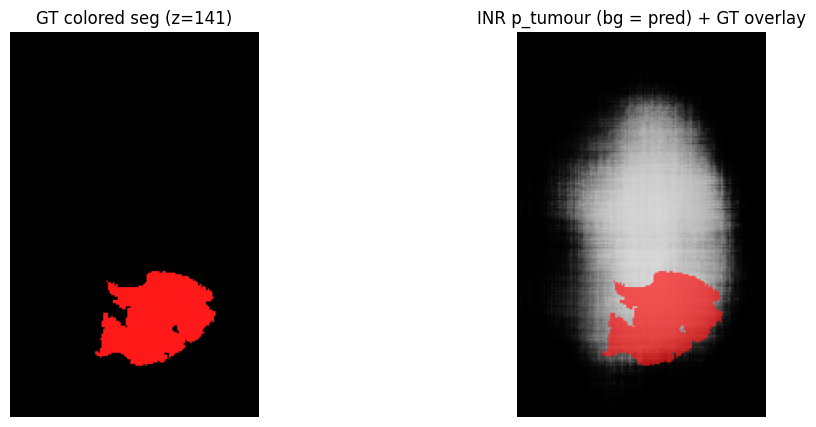

In [16]:
def colorize_labels(lbl2d: np.ndarray) -> np.ndarray:
    # Map 0->transparent black, 1->blue, 2->green, 4->red (like viewer LUT)
    h,w = lbl2d.shape
    rgb = np.zeros((h,w,3), dtype=np.float32)
    m1 = lbl2d==1; rgb[m1] = np.array([0.0, 0.4, 1.0])
    m2 = lbl2d==2; rgb[m2] = np.array([0.0, 0.8, 0.0])
    m4 = lbl2d==4; rgb[m4] = np.array([1.0, 0.1, 0.1])
    return rgb

if TORCH_OK and sampler.n > 0:
    lab = sampler.labels[0]  # integer labels if available, else binary
    D,H,W = lab.shape
    # pick slice with most positives
    pos_per_slice = lab.reshape(D, -1).sum(axis=1)
    z = int(np.argmax(pos_per_slice))
    xs = np.linspace(0, 1, W, dtype=np.float32)
    ys = np.linspace(0, 1, H, dtype=np.float32)
    Xg, Yg = np.meshgrid(xs, ys, indexing='xy')
    pts = np.stack([Xg.reshape(-1), Yg.reshape(-1), np.full(Xg.size, z/(D-1+1e-6), np.float32)], axis=1)
    with torch.no_grad():
        pred = torch.sigmoid(model(torch.from_numpy(pts).to(DEVICE))).cpu().numpy().reshape(H, W)
    # Colored GT overlay
    lbl2d = lab[z].astype(np.uint8)
    if lbl2d.max() <= 1:  # binary -> map to 4 (enhancing) for visibility
        lbl2d = (lbl2d*4).astype(np.uint8)
    color = colorize_labels(lbl2d)
    alpha = (lbl2d>0).astype(np.float32)[...,None]*0.7
    gt_rgb = (1-alpha)*np.stack([pred]*3, axis=-1) + alpha*color

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.title(f'GT colored seg (z={z})'); plt.imshow(color); plt.axis('off')
    plt.subplot(1,2,2); plt.title('INR p_tumour (bg = pred) + GT overlay'); plt.imshow(gt_rgb); plt.axis('off')
    plt.show()
else:
    print('Skip viz.')
